# Visualization of an HPL trace

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

In [2]:
archive_name = 'grenoble_2019-01-21_1841959.zip'
experiments = read_csv(archive_name, 'exp.csv')
sizes = list(experiments.matrix_size)
print(sizes)
experiments

[250000, 50000, 150000, 100000, 200000]


,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,8,32,1,2,2,1,0,8,32,1
1,50000,128,8,32,1,2,2,1,0,8,32,1
2,150000,128,8,32,1,2,2,1,0,8,32,1
3,100000,128,8,32,1,2,2,1,0,8,32,1
4,200000,128,8,32,1,2,2,1,0,8,32,1


In [3]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace['kind'] = 'BLAS'
    blas_trace['function'] = blas_trace['function'].str.strip()
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['duration'] = mpi_trace['end'] - mpi_trace['start']
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['exp_id'] = exp_id
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_%d.csv' % exp_id)
        df_links['exp_id'] = exp_id
    return df, df_links

traces = []
for i, size in enumerate(sizes):
    if size not in [100000, 200000, 250000]:
        continue
    tmp_trace, _ = read_archive(archive_name, 'reality', i)
    tmp_trace['matrix_size'] = size
    traces.append(tmp_trace)

trace_reality = pandas.concat(traces)
trace_reality.head()

# Mode: reality
	BLAS trace: 126422 lines
	MPI  trace: 156922 lines
Removed 15904 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: reality
	BLAS trace: 102468 lines
	MPI  trace: 121762 lines
Removed 15904 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: reality
	BLAS trace: 112584 lines
	MPI  trace: 145192 lines
Removed 15904 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,exp_id,matrix_size
0,0.000047,5.575997,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,31360.0,NaN,NaN,0,5.575950,5.575950,reality,1,0,250000
1,0.000007,5.576020,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,NaN,NaN,0,5.576013,5.576013,reality,1,0,250000
2,0.000001,5.576022,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,NaN,NaN,0,5.576021,5.576021,reality,1,0,250000
3,0.000013,5.664420,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,31359.0,NaN,NaN,0,5.664407,5.664407,reality,1,0,250000
4,0.000139,5.664560,../HPL_pdpancrT.c,dgemv,NaN,BLAS,234.0,31359.0,NaN,1.0,0,5.664421,5.664421,reality,1,0,250000


In [4]:
trace_reality[trace_reality['kind'] == 'MPI'].head()

,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,exp_id,matrix_size
7,0.000036,0.000287,NaN,MPI_Send,NaN,MPI,NaN,NaN,4.0,NaN,99,0.000251,NaN,reality,100,0,250000
10,0.017103,0.017392,NaN,MPI_Recv,NaN,MPI,NaN,NaN,4.0,NaN,99,0.000289,NaN,reality,100,0,250000
13,0.000003,0.017575,NaN,MPI_Send,NaN,MPI,NaN,NaN,8.0,NaN,99,0.017572,NaN,reality,100,0,250000
16,0.012959,0.030535,NaN,MPI_Recv,NaN,MPI,NaN,NaN,8.0,NaN,99,0.017576,NaN,reality,100,0,250000
19,0.000017,0.030553,NaN,MPI_Recv,NaN,MPI,NaN,NaN,8.0,NaN,99,0.030536,NaN,reality,100,0,250000


In [5]:
trace_reality[trace_reality['kind'] == 'BLAS'].head()

,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1,exp_id,matrix_size
0,0.000047,5.575997,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,31360.0,NaN,NaN,0,5.575950,5.575950,reality,1,0,250000
1,0.000007,5.576020,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,NaN,NaN,0,5.576013,5.576013,reality,1,0,250000
2,0.000001,5.576022,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,NaN,NaN,0,5.576021,5.576021,reality,1,0,250000
3,0.000013,5.664420,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,31359.0,NaN,NaN,0,5.664407,5.664407,reality,1,0,250000
4,0.000139,5.664560,../HPL_pdpancrT.c,dgemv,NaN,BLAS,234.0,31359.0,NaN,1.0,0,5.664421,5.664421,reality,1,0,250000


## Removing the initialization and the finalization in the traces

In [6]:
for exp in sorted(trace_reality['exp_id'].unique()):
    tmp = trace_reality[trace_reality['exp_id'] == exp]
    print('exp %d: %.2f → %.2f' % (exp, tmp['start'].min(), tmp['end'].max()))

exp 0: 0.00 → 28.56
exp 3: 0.00 → 4.76
exp 4: 0.00 → 17.80


In [7]:
def split(df):
    return [df[(df['rank'] == rank) & (df['exp_id'] == exp)] for rank in df['rank'].unique() for exp in df['exp_id'].unique()]

def crop(df, func_name):
    func_calls = df[df['function'] == func_name]
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    df = df[(df['start'] > start) & (df['end'] < end)].copy()
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

def crop_all(df, func_name):
    df_ranks = [crop(tmp_df, func_name) for tmp_df in split(df)]
    df = pandas.concat(df_ranks)
    return df

In [8]:
trace_reality = crop_all(trace_reality, 'MPI_Bcast')
for exp in sorted(trace_reality['exp_id'].unique()):
    tmp = trace_reality[trace_reality['exp_id'] == exp]
    print('exp %d: %.2f → %.2f' % (exp, tmp['start'].min(), tmp['end'].max()))

exp 0: 0.00 → 13.73
exp 3: 0.00 → 2.39
exp 4: 0.00 → 8.64


## Displaying the traces

In [9]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

In [10]:
def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

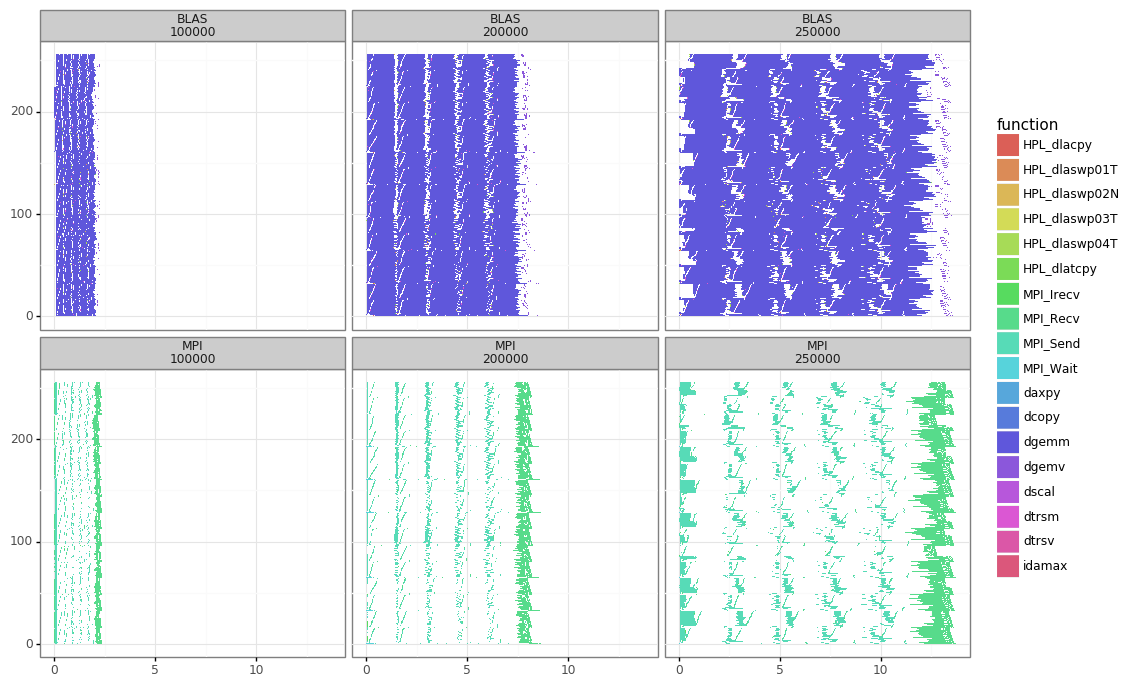

<ggplot: (8788464978594)>

In [11]:
plot(trace_reality, wrap=['kind', 'matrix_size'])

## Counting the number of events

In [12]:
trace_reality.groupby(['function', 'matrix_size'])[['duration']].agg(['count', 'sum'])

duration             
                             count          sum
function      matrix_size                      
HPL_dlacpy    100000            44     0.195476
              200000            46     0.423536
              250000            44     0.849795
HPL_dlaswp01T 100000           165     0.507809
              200000           165     1.098277
              250000           165     1.561567
HPL_dlaswp02N 100000          1153     0.920338
              200000          1155     2.466170
              250000          1133     3.559283
HPL_dlaswp03T 100000          1155     0.567743
              200000          1155     1.243556
              250000          1152     1.549328
HPL_dlaswp04T 100000          1154     2.277765
              200000          1155     4.645538
              250000          1144     6.499853
HPL_dlatcpy   100000          1895     0.290377
              200000          2009     0.631144
              250000          2244     0.796732
MPI_Irecv     100000         22392     0.491092
              200000         22392     0.842151
              250000         22392     1.758341
MPI_Recv      100000         13182    72.847911
              200000         24896   160.618329
              250000         30762   314.298312
MPI_Send      100000         35571    63.713244
              200000         47289   150.414765
              250000         53152   333.880563
MPI_Wait      100000         22392     0.660307
              200000         22392     3.282500
              250000         22392     1.501404
daxpy         100000          6220     0.005556
              200000         12468     0.011025
              250000         15596     0.014002
dcopy         100000         16835     0.011310
              200000         19609     0.018735
              250000         19212     0.022090
dgemm         100000         20300   432.250544
              200000         15793  1726.846179
              250000         17179  2717.052133
dgemv         100000         14817     3.558447
              200000         27632    14.547977
              250000         33742    22.988976
dscal         100000          5251     0.024135
              200000          5888     0.055626
              250000          5597     0.069998
dtrsm         100000         20300     4.084780
              200000         15793     7.594403
              250000         17178     9.161982
dtrsv         100000           782     0.018603
              200000          1563     0.040155
              250000          1954     0.050163
idamax        100000          5249     0.039571
              200000          5882     0.090924
              250000          5594     0.112446

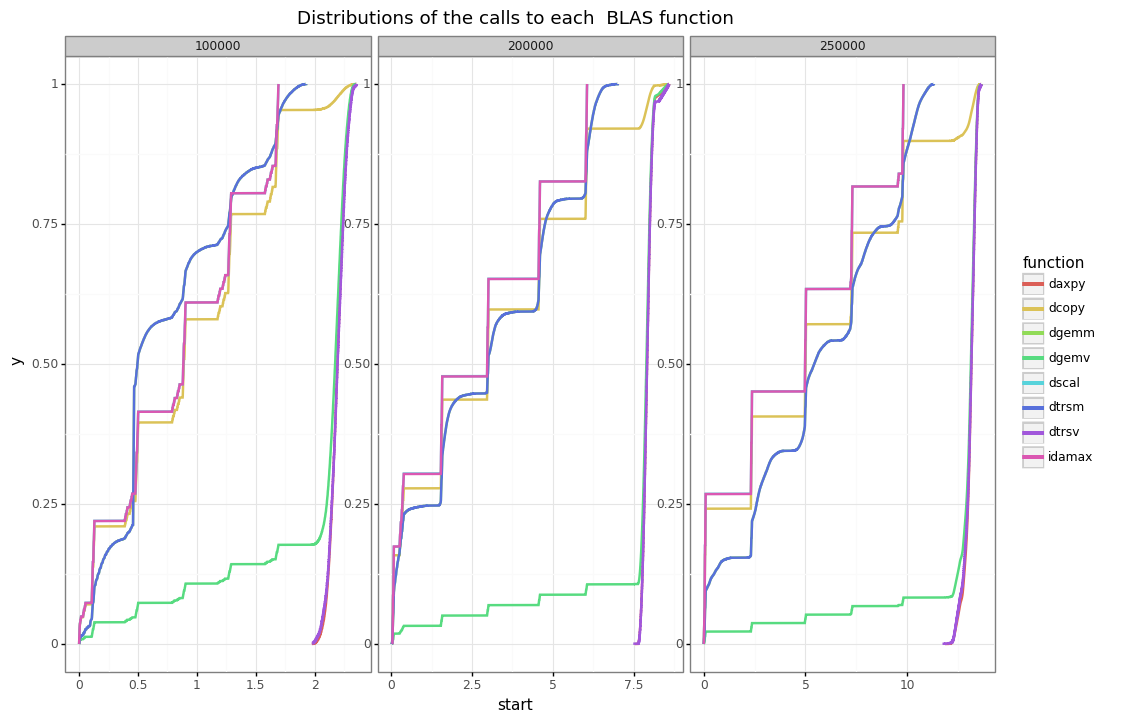

<ggplot: (-9223363248437279435)>

In [13]:
plot = ggplot(trace_reality[(trace_reality['kind'] == 'BLAS') & (~trace_reality.function.str.startswith('HPL_'))], aes('start', group='function', color='function'))
plot + stat_ecdf(size=1) + ggtitle('Distributions of the calls to each  BLAS function') + theme_bw() + facet_wrap('matrix_size', scales='free')

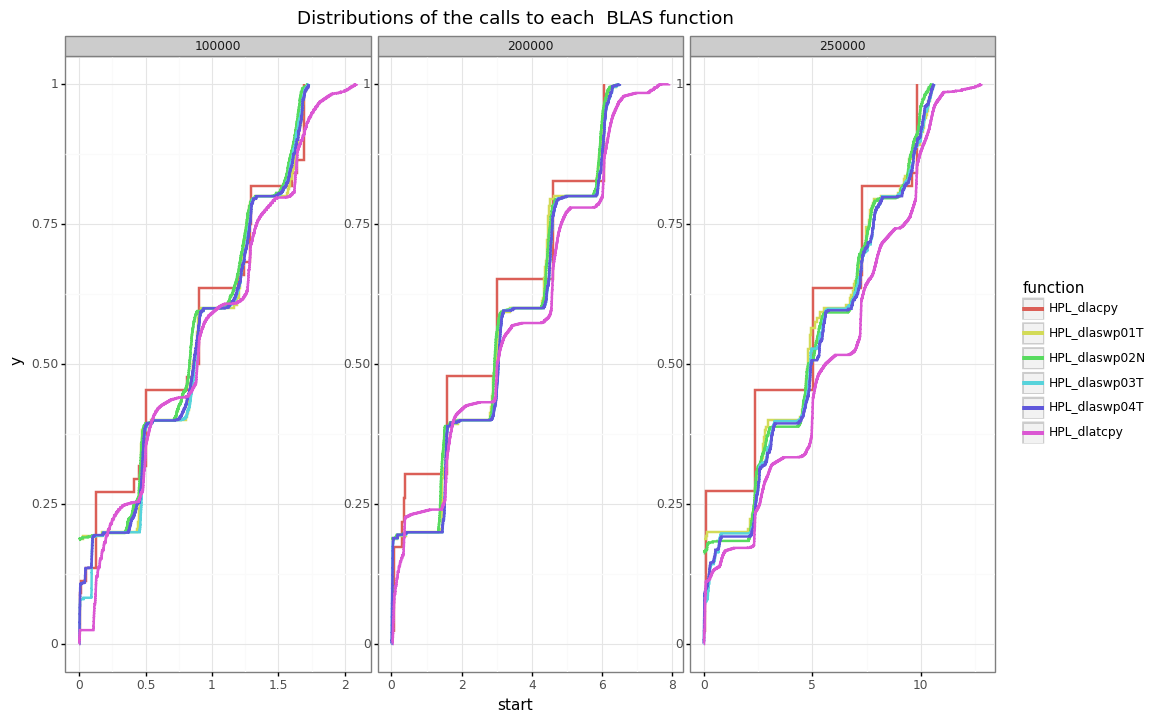

<ggplot: (-9223363248442360944)>

In [14]:
plot = ggplot(trace_reality[(trace_reality['kind'] == 'BLAS') & (trace_reality.function.str.startswith('HPL_'))], aes('start', group='function', color='function'))
plot + stat_ecdf(size=1) + ggtitle('Distributions of the calls to each  BLAS function') + theme_bw() + facet_wrap('matrix_size', scales='free')

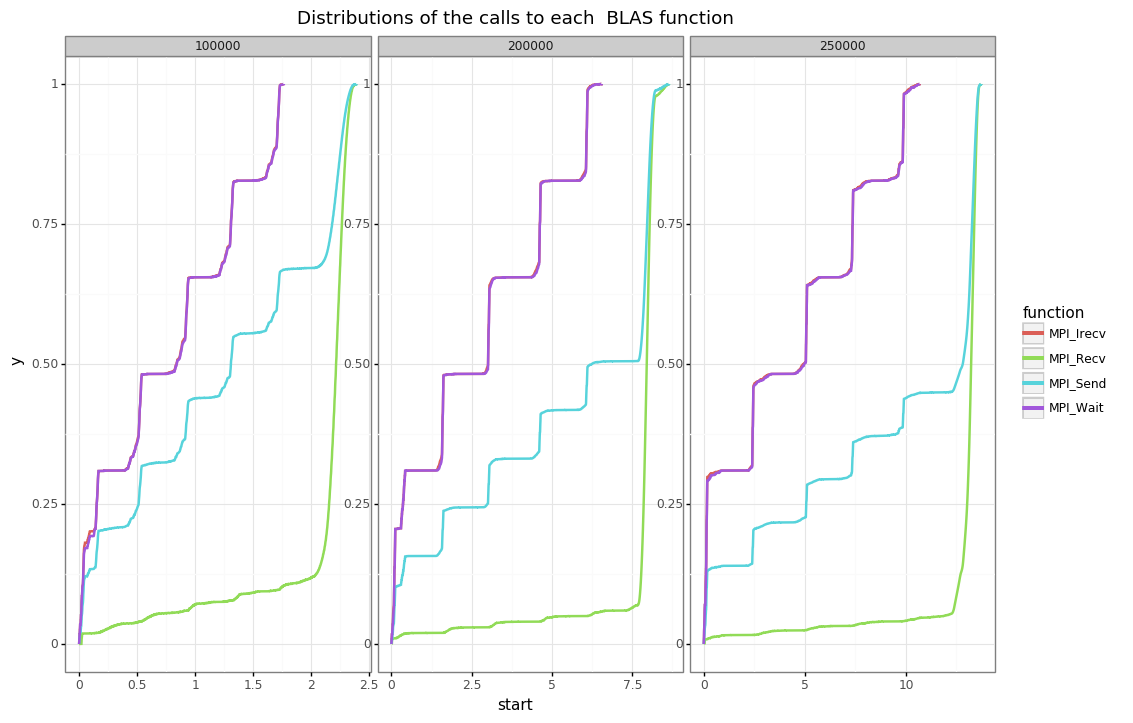

<ggplot: (-9223363248445357347)>

In [15]:
plot = ggplot(trace_reality[(trace_reality['kind'] == 'MPI')], aes('start', group='function', color='function'))
plot + stat_ecdf(size=1) + ggtitle('Distributions of the calls to each  BLAS function') + theme_bw() + facet_wrap('matrix_size', scales='free')

## Plotting the durations

In [16]:
blas = trace_reality[trace_reality['kind'] == 'BLAS'].copy().reset_index()
blas['size_product'] = -1
blas.loc[blas.function == 'dgemm', 'size_product'] = blas.m * blas.n * blas.k
blas.loc[blas.function == 'dtrsm', 'size_product'] = blas.m * blas.n**2
blas.loc[blas.function == 'dtrsv', 'size_product'] = blas.m**2
for func in ['dgemv']:
    blas.loc[blas.function == func, 'size_product'] = blas.m * blas.n
for func in ['daxpy', 'dcopy', 'dscal', 'idamax']:
    blas.loc[blas.function == func, 'size_product'] = blas.m

blas.loc[blas.function.str.startswith('HPL_'), 'size_product'] = blas.m * blas.n
for func in ['HPL_dlaswp04N', 'HPL_dlaswp04T']:
    blas.loc[blas.function == func, 'size_product'] = blas.n * blas.k

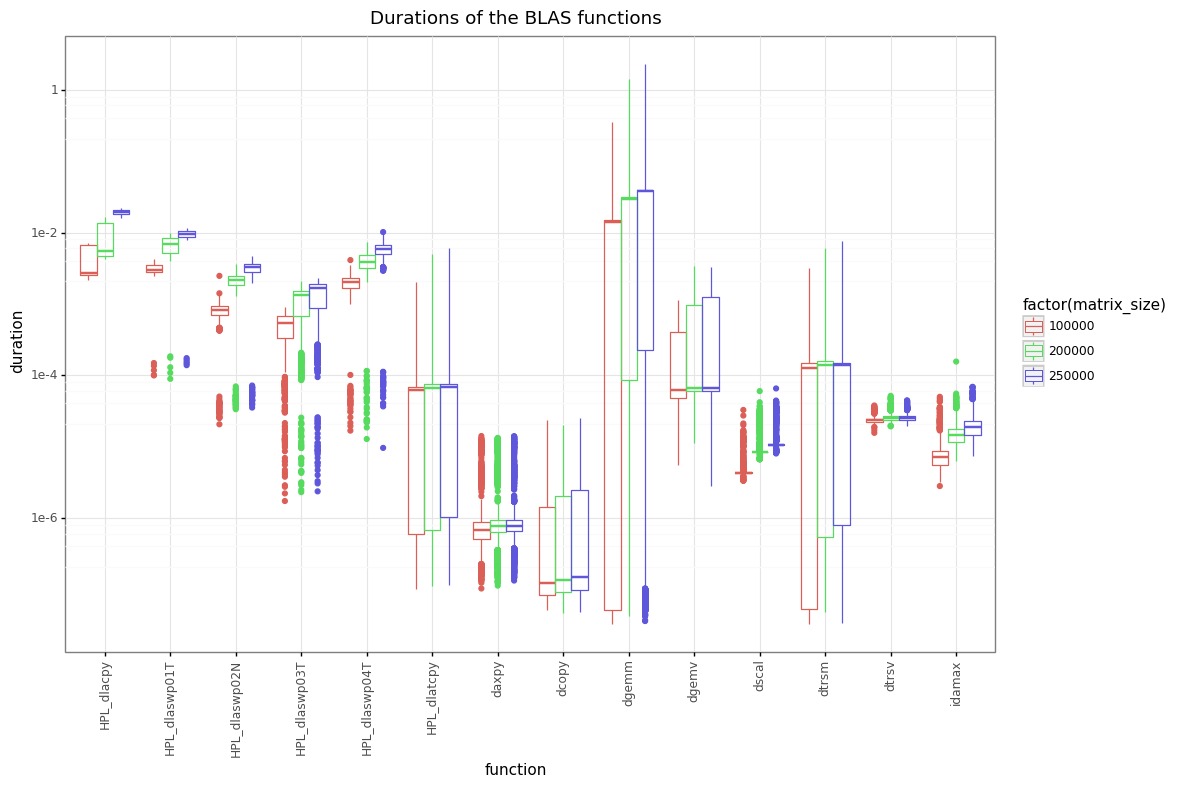

<ggplot: (8788417493291)>

In [17]:
plot = ggplot(blas, aes(x='function', y='duration', color='factor(matrix_size)')) + scale_y_log10()
plot = plot + theme_bw() + ggtitle('Durations of the BLAS functions') + geom_boxplot(alpha=0)
plot + theme(axis_text_x=element_text(rotation=90))

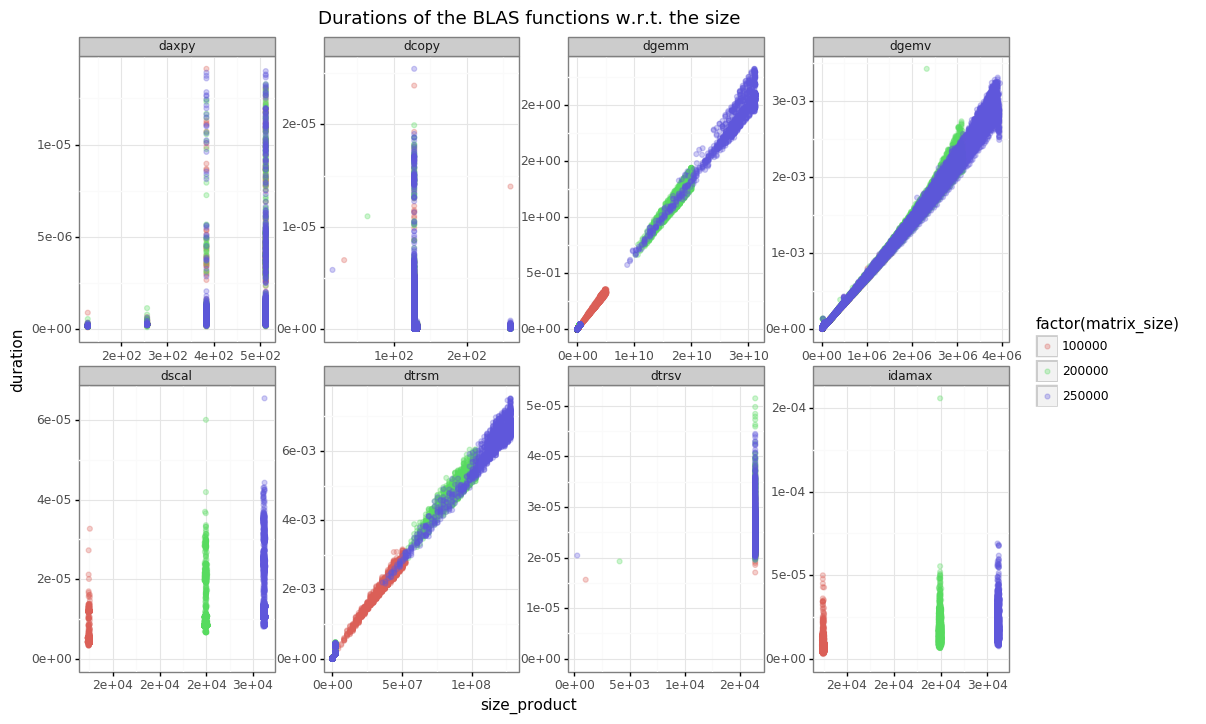

<ggplot: (8788398393597)>

In [18]:
def plot_size(df):
    my_label = lambda l: ['%.0e' % x for x in l]
    plot = ggplot(df, aes(x='size_product', y='duration', color='factor(matrix_size)')) + geom_point(alpha=0.3)
    plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
    plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25}) + expand_limits(y=0) # the subplots_adjust is to fix a display bug...
    return plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label)

plot_size(blas[~blas.function.str.startswith('HPL_')])

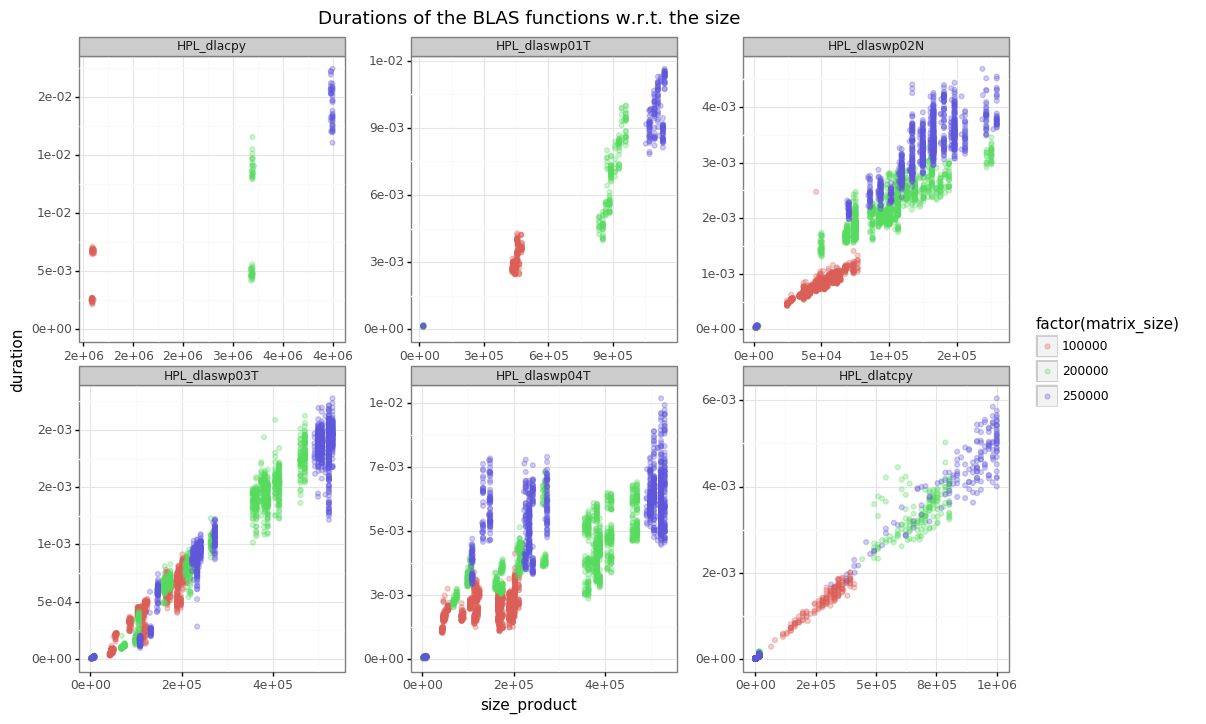

<ggplot: (-9223363248421818336)>

In [19]:
plot_size(blas[blas.function.str.startswith('HPL_')])

## Computing the coefficients

In [20]:
blas = blas[blas.size_product > 0].copy()
blas['ratio'] = blas['duration'] / blas['size_product']

def plot_hist(df, x):
    plot = ggplot(df, aes(x=x)) + geom_histogram(bins=30)
    plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Distribution of the %s' % x)
    plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25})  # the subplots_adjust is to fix a display bug...
    return plot

In [21]:
blas['large_size'] = False
for func in blas.function.unique():
    max_size = blas[blas['function'] == func]['size_product'].max()
    blas.loc[(blas['function'] == func) & (blas['size_product'] > max_size/3), 'large_size'] = True

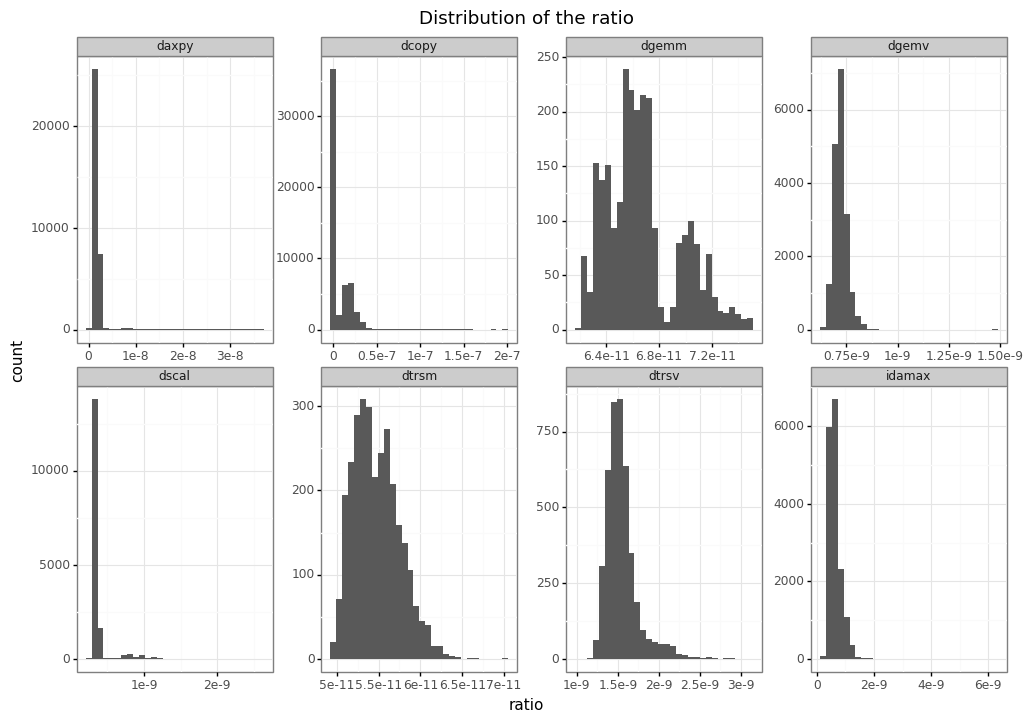

<ggplot: (-9223363248358470463)>

In [22]:
plot_hist(blas[(~blas.function.str.startswith('HPL_')) & (blas.large_size)], x='ratio')

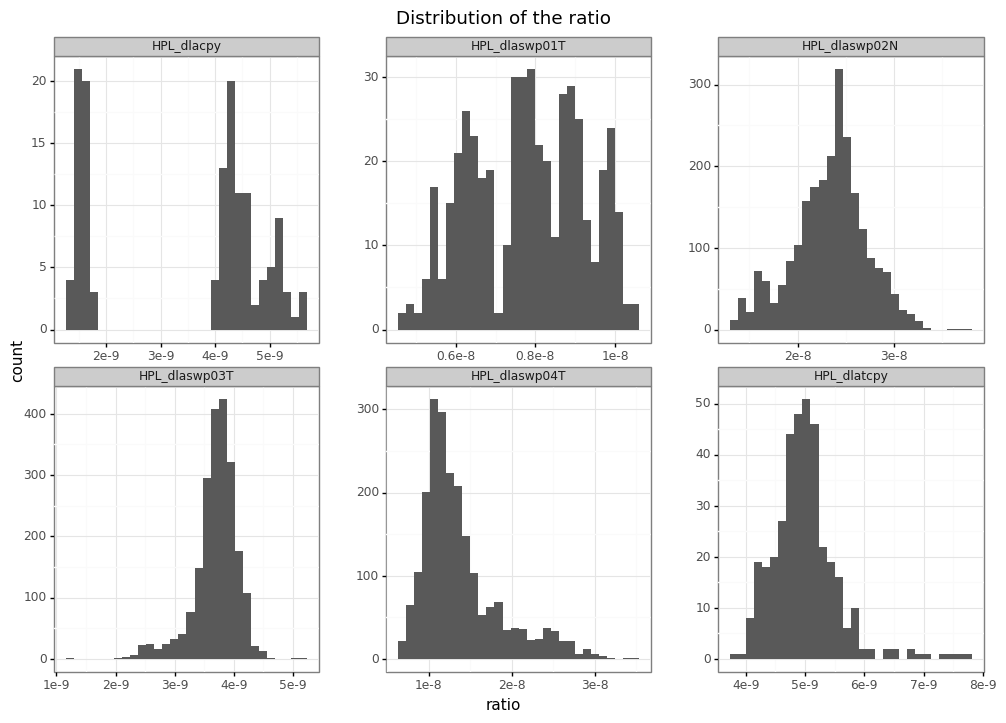

<ggplot: (8788409726251)>

In [23]:
plot_hist(blas[(blas.function.str.startswith('HPL_')) & (blas.large_size)], x='ratio')

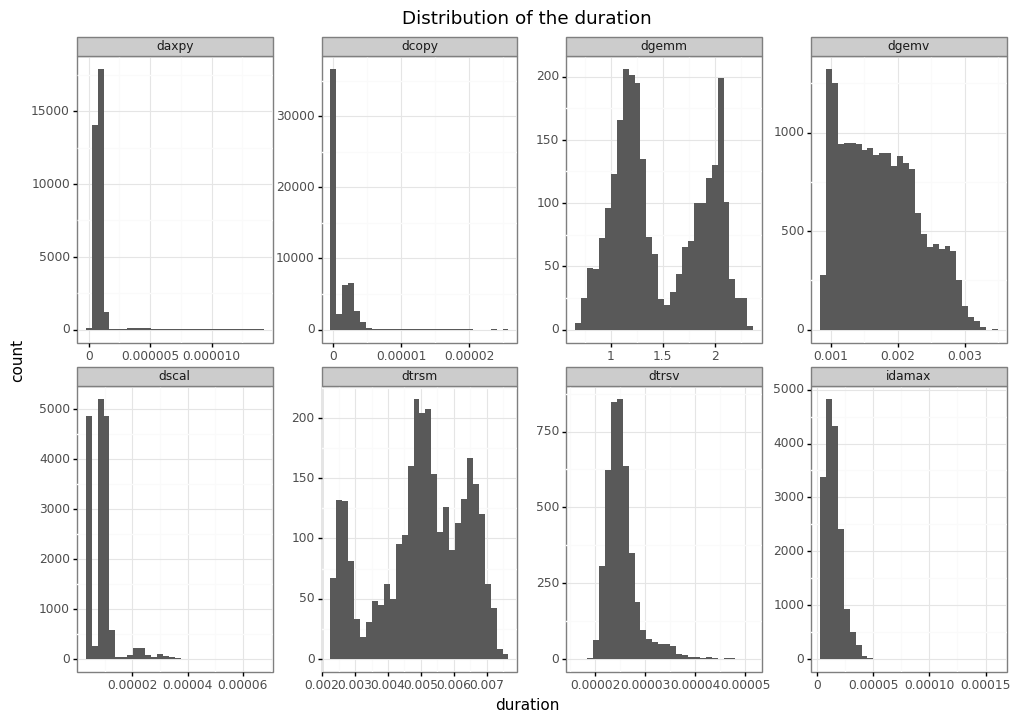

<ggplot: (8788404693887)>

In [24]:
plot_hist(blas[(~blas.function.str.startswith('HPL_')) & (blas.large_size)], x='duration')

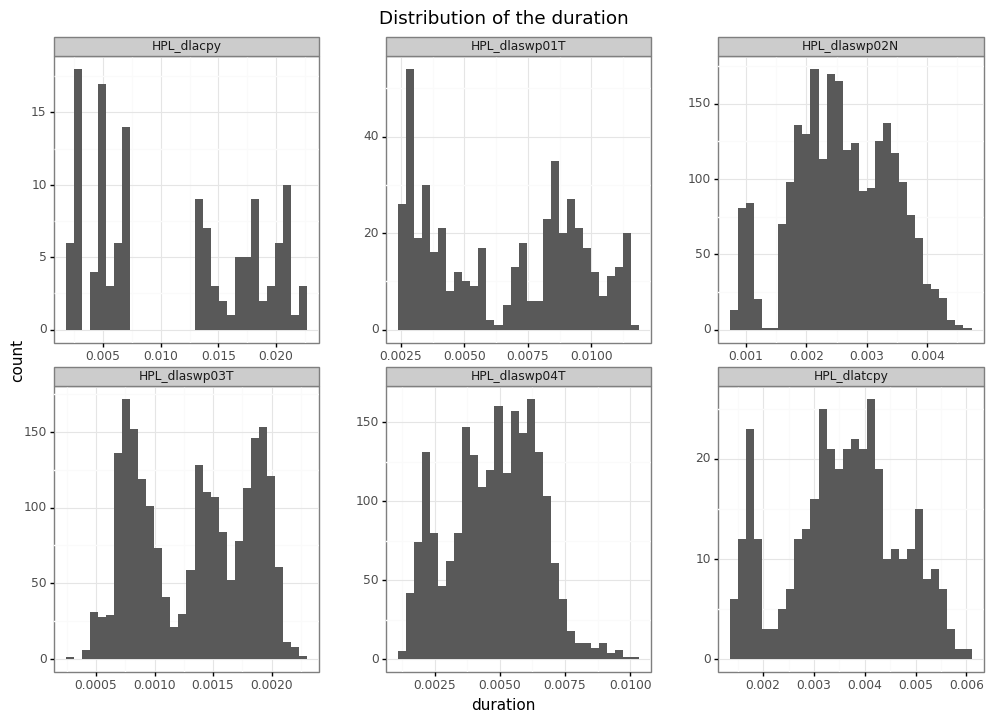

<ggplot: (8788404659446)>

In [25]:
plot_hist(blas[(blas.function.str.startswith('HPL_')) & (blas.large_size)], x='duration')

In [26]:
coefficients = blas[blas.large_size].groupby('function')[['ratio', 'duration']].agg(['mean', 'std']).reset_index()

In [27]:
coefficients

function         ratio                    duration              
                           mean           std          mean           std
0      HPL_dlacpy  3.493398e-09  1.501550e-09  1.096125e-02  6.930336e-03
1   HPL_dlaswp01T  7.802303e-09  1.397468e-09  6.594960e-03  2.943752e-03
2   HPL_dlaswp02N  2.335991e-08  3.824178e-09  2.588537e-03  8.134454e-04
3   HPL_dlaswp03T  3.693507e-09  3.686559e-10  1.332052e-03  4.816722e-04
4   HPL_dlaswp04T  1.382175e-08  4.762299e-09  4.771486e-03  1.690573e-03
5     HPL_dlatcpy  4.993149e-09  5.575860e-10  3.571074e-03  1.099442e-03
6           daxpy  1.822924e-09  2.016940e-09  8.959811e-07  9.720740e-07
7           dcopy  7.237379e-09  1.160612e-08  9.363645e-07  1.480951e-06
8           dgemm  6.674909e-11  2.758832e-12  1.478533e+00  4.290012e-01
9           dgemv  7.208630e-10  3.235424e-11  1.752474e-03  5.660120e-04
10          dscal  3.831406e-10  1.457702e-10  8.948297e-06  4.981691e-06
11          dtrsm  5.474621e-11  2.737621e-12  5.025146e-03  1.334568e-03
12          dtrsv  1.546688e-09  2.055262e-10  2.534093e-05  3.367342e-06
13         idamax  6.234814e-10  2.403032e-10  1.452562e-05  7.671488e-06

In [28]:
import numpy
blas['coefficient'] = -1
for func in coefficients.function.unique():
    size = len(blas[blas.function == func])
    func_row = coefficients[coefficients.function == func]
    mean_ratio = list(func_row['ratio']['mean'])[0]
    std_ratio = list(func_row['ratio']['std'])[0]
    mean_duration = list(func_row['duration']['mean'])[0]
    std_duration = list(func_row['duration']['std'])[0]
    blas.loc[blas.function == func, 'exp_ratio'] = numpy.random.normal(loc=mean_ratio, scale=std_ratio, size=size)
    blas.loc[blas.function == func, 'exp_duration'] = numpy.random.normal(loc=mean_duration, scale=std_duration, size=size)

In [29]:
linear_functions = {'dgemm', 'dgemv', 'dtrsm', 'HPL_dlaswp02N', 'HPL_dlaswp03T', 'HPL_dlatcpy'}
blas['estimation'] = -1

for func in set(blas.function.unique()) & linear_functions:
    tmp = blas[blas.function == func]
    blas.loc[blas.function == func, 'estimation'] = tmp['size_product'] * tmp['exp_ratio']

for func in set(blas.function.unique()) - linear_functions:
    tmp = blas[blas.function == func]
    blas.loc[blas.function == func, 'estimation'] = tmp['exp_duration']

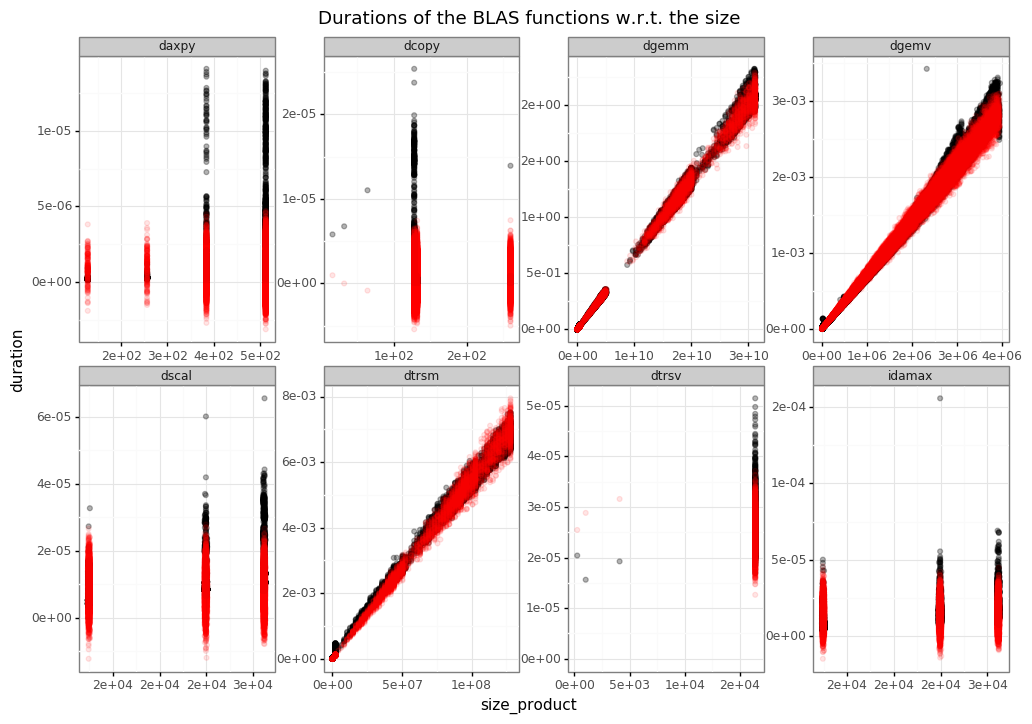

<ggplot: (8788399299795)>

In [30]:
my_label = lambda l: ['%.0e' % x for x in l]
plot = ggplot(blas[~blas.function.str.startswith('HPL_')], aes(x='size_product', y='duration')) + geom_point(alpha=0.3)
plot = plot + geom_point(aes(x='size_product', y='estimation'), color='red', alpha=0.1)
plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25})  # the subplots_adjust is to fix a display bug...
plot = plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label) + expand_limits(y=0)
plot

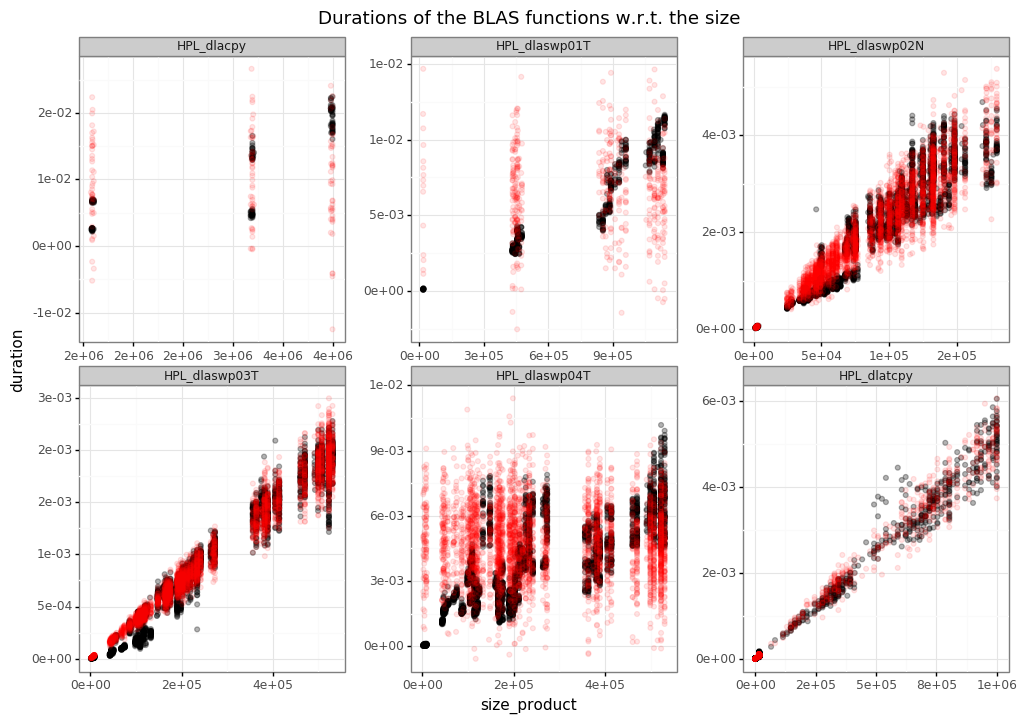

<ggplot: (8788397196741)>

In [31]:
plot = ggplot(blas[blas.function.str.startswith('HPL_')], aes(x='size_product', y='duration')) + geom_point(alpha=0.3)
plot = plot + geom_point(aes(x='size_product', y='estimation'), color='red', alpha=0.1)
plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25})  # the subplots_adjust is to fix a display bug...
plot = plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label) + expand_limits(y=0)
plot

In [32]:
blas.groupby('function')[['duration', 'estimation']].agg(['sum', 'min', 'max'])

duration                           estimation                \
                       sum           min       max          sum           min   
function                                                                        
HPL_dlacpy        1.468807  2.152988e-03  0.022415     1.357633 -1.249100e-02   
HPL_dlaswp01T     3.167653  8.929400e-05  0.011637     3.308939 -2.512742e-03   
HPL_dlaswp02N     6.945791  2.060200e-05  0.004689     7.157356  1.979236e-05   
HPL_dlaswp03T     3.360628  1.732000e-06  0.002276     3.418116  4.926311e-06   
HPL_dlaswp04T    13.423157  9.619000e-06  0.010182    16.605509 -5.797157e-04   
HPL_dlatcpy       1.718253  1.010000e-07  0.006047     1.772192  1.477063e-08   
daxpy             0.030583  1.030000e-07  0.000014     0.030599 -3.147267e-06   
dcopy             0.052135  4.700000e-08  0.000025     0.051716 -5.448546e-06   
dgemm          4876.147996  3.850400e-05  2.321973  4783.952367  2.883073e-06   
dgemv            41.095400  2.806000e-06  0.003420    40.659194  4.140227e-06   
dscal             0.149759  3.324000e-06  0.000065     0.148957 -1.222430e-05   
dtrsm            20.840218  2.530000e-07  0.007518    19.681934  3.366429e-10   
dtrsv             0.108920  1.562600e-05  0.000051     0.109031  1.264228e-05   
idamax            0.242941  2.808000e-06  0.000156     0.242355 -1.513237e-05   

                         
                    max  
function                 
HPL_dlacpy     0.026605  
HPL_dlaswp01T  0.014666  
HPL_dlaswp02N  0.005375  
HPL_dlaswp03T  0.002494  
HPL_dlaswp04T  0.011409  
HPL_dlatcpy    0.006060  
daxpy          0.000005  
dcopy          0.000007  
dgemm          2.290338  
dgemv          0.003095  
dscal          0.000028  
dtrsm          0.007945  
dtrsv          0.000037  
idamax         0.000046